In [1]:
%matplotlib inline

from importlib import reload
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

from scipy.stats import invwishart, invgamma

# скачаем данные
dta = sm.datasets.macrodata.load_pandas().data
dta.index = pd.date_range('1959Q1', '2009Q3', freq='QS')

Посмотрим на данные.

In [2]:
dta.head()

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
1959-01-01,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.98,139.7,2.82,5.8,177.146,0.00,0.00
1959-04-01,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.15,141.7,3.08,5.1,177.830,2.34,0.74
1959-07-01,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.35,140.5,3.82,5.3,178.657,2.74,1.09
1959-10-01,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.37,140.0,4.33,5.6,179.386,0.27,4.06
1960-01-01,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.54,139.6,3.50,5.2,180.007,2.31,1.19


### Модель TVP-VAR в Statsmodels.

Основная цель использования Байесовских методов в данном случае - получить апостериорное распределение вектора скрытых состояний. 

Обычно, помимо MCMC, для этого используются две альтернативных процедуры:
* Фильтр Калмана
* Факторный алгоритм Холецкого

#### Одномерная модель

Для начала рассмотрим одномерную state space модель. Наблюдения: $y_t$, ненаблюдаемый тренд: $\mu_t$.

$$
\begin{aligned}
y_t = \mu_t + \varepsilon_t,\; \varepsilon_t \sim N(0, \sigma^2_{\textrm{irregular}}) \\[5pt]
\mu_t = \mu_{t-1} + \eta_t,\; \eta_t \sim N(0, \sigma^2_{\textrm{trend}}) \\
\end{aligned}
$$

То есть и наблюдаемая переменная, и скрытая - случайное блуждание. Мы заинтересованы насэмплировать наблюдения из апостериорного распределения для скрытого вектора состояния, то есть мы хотим получить выборку из

$$
p(\mu^t \; | \; y^t, \sigma^2_{irregular}, \sigma^2_{level})
$$

Где $\mu^t = (\mu_1, ..., \mu_T)'$ и $y^t = (y_1, ..., y_T)'$.

В `Statsmodels` модель скрытого уровня относится к более общему классу `Unobserved components` и может быть создана следующим образом:

In [4]:
# если посмотреть в справке, там куча разных спецификаций state space моделей
mod = sm.tsa.UnobservedComponents(dta.infl, 'llevel')

# Оценим sigma2_varepsilon, sigma2_eta с помощью ММП
res = mod.fit()
print(res.params)

# создадим объекты, которые могут сэмплировать из апостериорного распределения
sim_kfs = mod.simulation_smoother()              # default method is KFS
sim_cfa = mod.simulation_smoother(method='cfa')  # can specify CFA method
# у объектов есть метод simulate(), он генерирует новые выборки при каждом запуске

sigma2.irregular    3.373368
sigma2.level        0.744712
dtype: float64


In [8]:
%%time
NSIMULATIONS = 20

# создадим пустые датафреймы для хранения результатов симуляций
simulated_kfs = pd.DataFrame(np.zeros((mod.nobs, NSIMULATIONS)), index = dta.index)
simulated_cfa = pd.DataFrame(np.zeros((mod.nobs, NSIMULATIONS)), index = dta.index)

for i in range(NSIMULATIONS):
    # будем запускать симуляции и сохранять их результаты
    sim_kfs.simulate()
    simulated_kfs.iloc[:, i] = sim_kfs.simulated_state[0]
    
    sim_cfa.simulate()
    simulated_cfa.iloc[:, i] = sim_cfa.simulated_state[0]

Wall time: 279 ms


Нарисуем результаты.

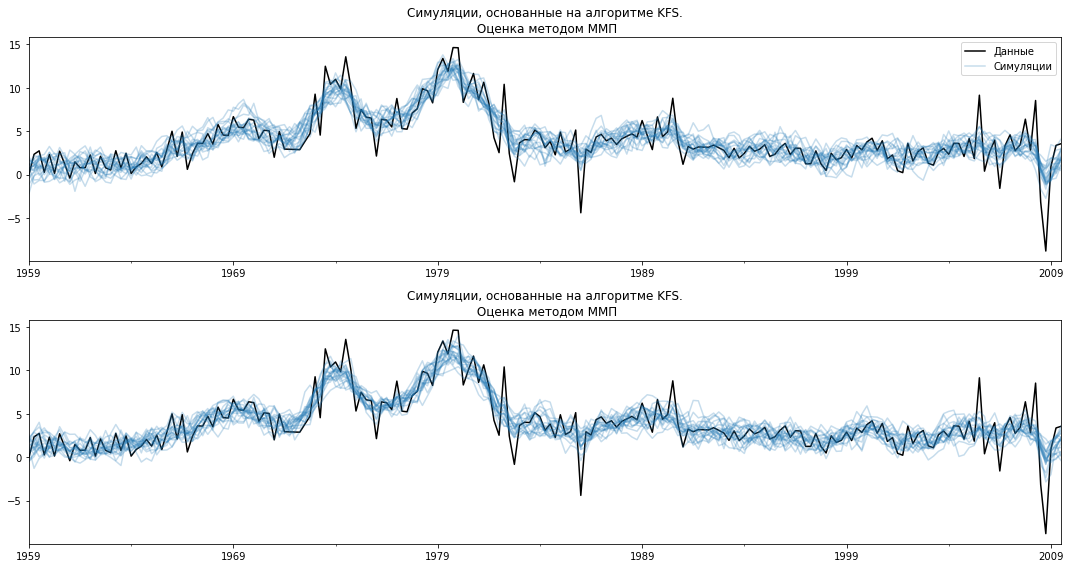

In [12]:
fig, ax = plt.subplots(2, figsize=(15, 8))

# собственно график
# KFS
dta.infl.plot(ax = ax[0], color='k')
ax[0].set_title('Симуляции, основанные на алгоритме KFS.\n Оценка методом ММП')
simulated_kfs.plot(ax=ax[0], color='C0', alpha=0.25, legend=False)

# CFA
dta.infl.plot(ax = ax[1], color='k')
ax[1].set_title('Симуляции, основанные на алгоритме KFS.\n Оценка методом ММП')
simulated_cfa.plot(ax=ax[1], color='C0', alpha=0.25, legend=False)

# добавим легенду, настроим график
handles, labels = ax[0].get_legend_handles_labels()
ax[0].legend(handles[:2], ['Данные', 'Симуляции'])
fig.tight_layout();

#### Обновление параметров модели.

Каждый раз, когда мы обновляем параметры модели в объекте `mod`, это учитывается при запуске метода `simulate()`. Это удобно для MCMC, который обновляет параметры, делает выборку из апостериорного распределения для вектора состояний и затем обновляет параметры модели. То есть, видимо, авторы нам хотят сказать, что класс удобно сконструирован, чтобы MCMC мог сэмплить из апостериорного.

Попробуем изменить параметры модели так, чтобы тренд был более сглаженным, на примере KFS.

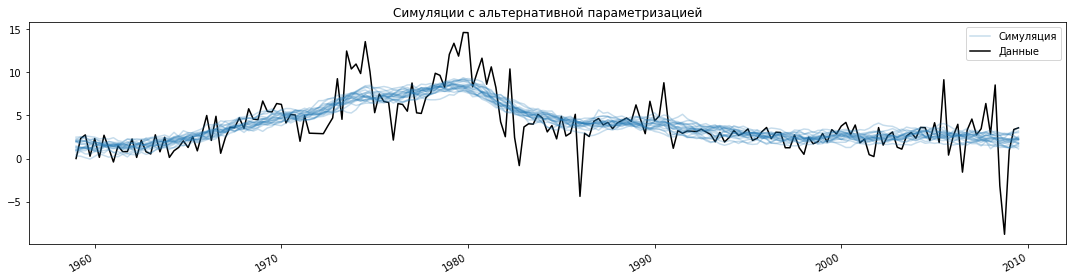

In [14]:
fig, ax = plt.subplots(figsize=(15, 4))

# обновим параметры модели
# сгладим дисперсию ошибки для ненаблюдаемого тренда
mod.update([4, 0.05])

# нарисуем симуляции
for _ in range(NSIMULATIONS):
    sim_kfs.simulate()
    ax.plot(dta.index, sim_kfs.simulated_state[0], 
            color='C0', alpha=0.25, label='Симуляция')

dta.infl.plot(ax=ax, color='k', label='Данные', zorder=-1)    
# легенда и все прочее
ax.set_title('Симуляции с альтернативной параметризацией')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[-2:], labels[-2:])
fig.tight_layout();

### Байесовское оценивание TVP-VAR с помощью MCMC.

Chan, Jliazkov (2009) оценили эту модель для 4 переменных (видимо, классический набор данных из `vars`):
* Реальный рост ВВП.
* Инфляция.
* Безработица.
* Краткосрочные % ставки.

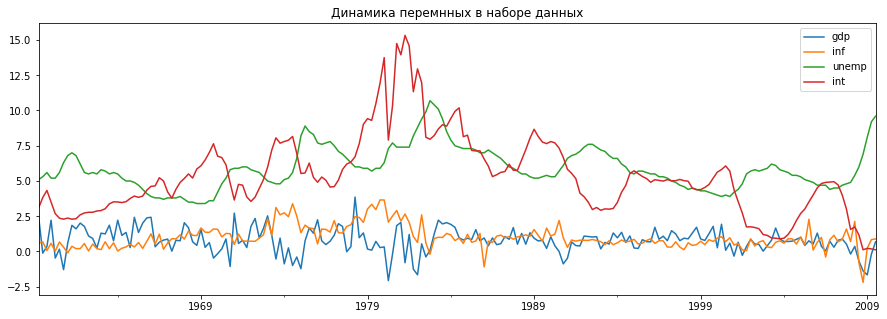

In [17]:
y = dta[['realgdp', 'cpi', 'unemp', 'tbilrate']].copy()
y.columns = ['gdp', 'inf', 'unemp', 'int']

# посчитаем рост ВВП и инфляцию
y[['gdp', 'inf']] = np.log(y[['gdp', 'inf']]).diff() * 100
y = y.iloc[1:]

fig, ax = plt.subplots(figsize=(15, 5))
y.plot(ax=ax)
ax.set_title('Динамика перемнных в наборе данных');

#### Собственно модель.

Обычно VAR(1) в сокращенной форме и векторном виде записывается так:

$$
y_t = \mu + \Phi y_{t-1} + \varepsilon_t, \; \varepsilon_t \sim N(0, H)
$$

$H$ - ковариационная матрица, видимо, диагональная.

Теперь переформатируем все параметры модели в вектор $\alpha_t = vec\big([\mu_t: \Phi_t]\big)$, где $vec$ - оператор, который переводит все столбцы матрицы в один вектор. Запишем уравнение для произвольного $i$-го коэффициента из вектора коэффициентов:

$$
\alpha_{i, t+1} = \alpha_{i, t} + \eta_{i,t},\; \eta_{i,t} \sim N(0, \sigma^2_i)
$$

То есть каждый параметр ведет себя как случайное блуждание.

Так как у нас $p$ переменных, то имеем $p$ наблюдений в векторе $\mu_t$ и $p^2$ наблюдений в марице $\Phi_t$, поэтому вектор $\alpha$ имеет размерность $p \cdot (p + 1) \times 1$.

Теперь запишем VAR(1) в формате модели "состояние-наблюдение" через SUR:

$$
\begin{gather}
    y_t = Z_t \alpha_t + \varepsilon_t, \;\; \varepsilon_t \sim N(0, H) \\[5pt]
    \alpha_{t+1} = \alpha_t + \eta_t, \;\; \eta_t \sim N \big(0, diag(\{\sigma^2_i\}) \big) 
\end{gather}
$$

Где 

$$
Z_t = 
\begin{bmatrix}
    1 & y^{T}_{t-1} & 0 & \dots & \; \; & 0 \\
    0 & 0 & 1 & y^T_{t-1} & \; \;  & 0 \\
    \vdots & \vdots & \vdots & \ddots & \ddots \\
    0 & 0 & 0 & 0 & 1 & y^T_{t-1}
\end{bmatrix}
$$

Прикол на самом деле в том, что $1$ в матрице выше - это вектор $(1, 0, 0, 0)$, а $0$ - это вектор $(0, 0, 0, 0)$, с размерностью самой нижней строки, авторы, видимо, немного напутали. У меня вышло, что матрица должна иметь размерность $p \times p \cdot (p+1)$. 

Возможен и другой вариант: допустим, $\alpha_t$ имеет вид

$$
\alpha_t = 
\begin{pmatrix}
    \mu_1 \\
    \alpha_{11} \\
    \alpha_{12} \\
    \alpha_{13} \\
    \alpha_{14} \\
    \mu_2 \\
    \alpha_{21} \\
    \alpha_{22} \\
    \vdots \\
    \mu_3 \\
    \vdots
\end{pmatrix}
+ \varepsilon_t
$$

Здесь я пренебрег индексами времени в векторе, но такой вариант выглядит более правдоподобным. Тогда векторную форму в матрице $Z_t$ имеют только нули.

Алгоритм CFA может работать только когда матрица $H$ имеет полный ранг, то есть все дисперсии, стоящие на диагонали, ненулевые.

Нам также нужно выбрать априорное распределение для $\alpha_1$. Как и в Chan, Jeliazkov (2009) мы предположим, что $\alpha_1 \sim N(0, 5I)$. Логичный выбор - стандартизированное нормальное распределение. Другие параметры - $H, \sigma^2_i$ - будут стабильны во времени в рамках оцениваемой модели.

#### Реализация модели в `Statsmodels`.

1. Создадим новый объект `TVPVAR` класса `sm.tsa.statespace.MLEModel`.
2. Загрузим в него известную информацию (временные ряды и матрицы, которые мы задали для системы состояние-наблюдение).
3. Зададим инициализацию $\alpha_1$.
4. Создадим метод для обновления матриц системы с помощью новых значений для ковариационной матрицы $H$ и дисперсий случайного блуждания $\sigma^2_i$.

В Statsmodels модель state space в общем виде реализована следующим образом:

$$
\begin{gather}
    y_t = d_t + Z_t \alpha_t + \varepsilon_t, \; \; \varepsilon_t \sim N(0, H_t) \\
    \alpha_{t+1} = c_t + T_t \alpha_t + R_t \eta_t, \; \; \eta_t \sim N(0, Q_t)
\end{gather}
$$

Наложим ограничения в рамках спецификации модели TVP-VAR(1):
* Константы равны нулю: $c_t = d_t = 0$
* Матрица $Z_t$ меняется во времени, но заполнена константами - единицами и векторами наблюдений.
* $T = I$
* $R = I$
* $H_t = H_{t-1} = H$
* $Q_t = Q_{t-1} = Q = diag(\{\sigma^2_i\})$

In [21]:
data = np.arange(1, 7).reshape((-1, 2))
data
sm.tsa.lagmat(data, 
              # максимальный лаг, который включается в данные
              1, 
              # обрезать ли лишние строки сверху или снизу
              # если backward или forward, то пропуски по дефолту заполняются нулями
              trim='both', 
              # добавлять ли исходный ряд к матрице с лагами
              original='in')

array([[1, 2],
       [3, 4],
       [5, 6]])

array([[3., 4., 1., 2.],
       [5., 6., 3., 4.]])

In [22]:
class TVPVAR(sm.tsa.statespace.MLEModel):
    # шаги 2-3 будем делать внутри конструктора класса
    def __init__(self, y):
        # матрица [y_t' : y_{t-1}'] для t = 2, ..., T
        augmented = sm.tsa.lagmat(y, 1, trim='both', original='in', use_pandas=True)
        # разделим на y_t и z_t = [1 : y_{t-1}']
        print(augmented)
        p = y.shape[1]
        y_t = augmented.iloc[:, :p]
        z_t = sm.add_constant(augmented.iloc[:, p:])
        print(f"y_t: {y_t}")
        print(f"z_t: {z_t}")
        
        # Вспомним, что длина вектора состояния равна p * (p + 1)
        k_states = p * (p + 1)
        super().__init__(y_t, exog=z_t, k_states=k_states)
        
        # по умолчанию матрицы модели "состояние-наблюдение" заполнены нулями
        # поэтому нет нужды руками прописывать, что c_t = d_t = 0
        
        # теперь зададим матрицу Z_t
        # -> self.k_endog = p размерность наблюдаемого вектора
        # -> self.k_states = p * (p + 1) размерность преобразованного вектора коэфф-тов
        # -> self.nobs = T число наблюдений y_t
        
        print(f"self.k_endog: {self.k_endog}")
        self['design'] = np.zeros((self.k_endog, self.k_states, self.nobs))
        print(f"self.design: {self['design']}")
        print(f"design shape: {self['design'].shape}")
        for i in range(self.k_endog):
            start = i * (self.k_endog + 1)
            end = start + self.k_endog + 1
            print(f"start: {start}")
            print(f"end: {end}")
            self['design', i, start:end, :] = z_t.T
            
        # зададим матрицу T = I
        self['transition'] = np.eye(k_states)
        
        # зададим матрицу R = I
        self['selection'] = np.eye(k_states)
        
        # Шаг 3: инициализируем вектор состояния как alpha_1 ~ N(0, 5I)
        self.ssm.initialize('known', stationary_cov=5 * np.eye(self.k_states))
        
    # Шаг 4: создадим метод для обновления ковариационных матриц H и Q
    def update_variance(self, obs_cov, state_cov_diag):
        self['obs_cov']  = obs_cov
        self['state_cov'] = np.diag(state_cov_diag)
        
    # наконец, определим человекочитаемые имена для каждого элемента
    # вектора состояния
    @property
    def state_names(self):
        state_names = np.empty((self.k_endog, self.k_endog + 1), dtype=object)
        for i in range(self.k_endog):
            endog_name = self.endog_names[i]
            state_names[i] = (
            [f"intercept.{endog_name}"] +
            [f"L1.{other_name}->{endog_name}"] for other_name in self.endog_names
            )
            
        return state_names.ravel().tolist()
        

In [23]:
mod = TVPVAR(y)

                 gdp       inf  unemp   int   gdp.L.1   inf.L.1  unemp.L.1  \
1959-07-01 -0.119295  0.683763    5.3  3.82  2.494213  0.584898        5.1   
1959-10-01  0.349453  0.068120    5.6  4.33 -0.119295  0.683763        5.3   
1960-01-01  2.219018  0.577153    5.2  3.50  0.349453  0.068120        5.6   
1960-04-01 -0.468455  0.033847    5.2  2.68  2.219018  0.577153        5.2   
1960-07-01  0.163288  0.674539    5.6  2.36 -0.468455  0.033847        5.2   
...              ...       ...    ...   ...       ...       ...        ...   
2008-07-01 -0.678136 -0.790362    6.0  1.17  0.361443  2.132732        5.4   
2008-10-01 -1.380483 -2.197901    6.9  0.12 -0.678136 -0.790362        6.0   
2009-01-01 -1.661198  0.233968    8.1  0.22 -1.380483 -2.197901        6.9   
2009-04-01 -0.185125  0.841884    9.2  0.18 -1.661198  0.233968        8.1   
2009-07-01  0.686219  0.889402    9.6  0.12 -0.185125  0.841884        9.2   

            int.L.1  
1959-07-01     3.08  
1959-10-01     3.82